In [1]:
# Makes print and division act like Python 3
from __future__ import print_function, division

# Import the usual libraries
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# Enable inline plotting at lower left
%matplotlib inline
matplotlib.rcParams['image.origin'] = 'lower'
matplotlib.rcParams['image.interpolation'] = 'none'

# seaborn package for making pretty plots, but not necessary
try:
    import seaborn as sns
    params =   {'xtick.direction': 'in', 'ytick.direction': 'in', 'font.family': ['serif'],
                'text.usetex': True, 'text.latex.preamble': ['\usepackage{gensymb}']}
    sns.set_style("ticks", params)
except ImportError:
    print('Seaborn module is not installed.')
    
from IPython.display import display, Latex

In [2]:
import pynrc
from pynrc import nrc_utils
from pynrc.nrc_utils import (webbpsf, poppy, pix_noise)

from pynrc import speckle_noise as sn

import astropy.io.fits as fits
import multiprocessing as mp

In [3]:
pynrc.setup_logging('WARNING', verbose=False)

In [4]:
data_path = webbpsf.utils.get_webbpsf_data_path() + '/'
opd_path = data_path + 'NIRCam/OPD/'
opd_file = 'OPD_RevV_nircam_132.fits'
opds, header = fits.getdata(opd_path + opd_file, header=True)

In [5]:
nopd = opds.shape[0]
nproc = int(np.min([nopd,mp.cpu_count()*0.75]))

In [6]:
# Multiprocessing or each OPD
%time opds_all = sn.opd_extract_mp(opds, header)

CPU times: user 1.67 s, sys: 3.57 s, total: 5.24 s
Wall time: 55.7 s


In [68]:
%time opd_obj = sn.OPD_extract(opds[0,], header)

CPU times: user 25.9 s, sys: 3.56 s, total: 29.5 s
Wall time: 29.4 s


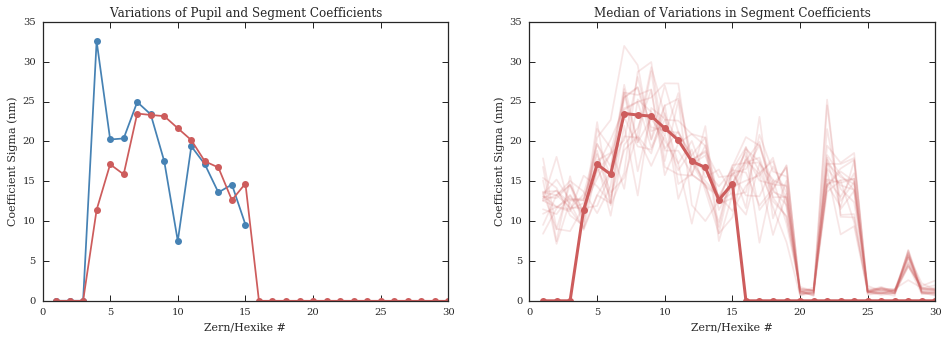

In [7]:
# For the pupil OPD and each segment OPD, find the stdev of each Zern/Hexike coefficient
pup_cf_std = np.array([opds_all[i].coeff_pupil for i in range(nopd)]).std(axis=0)

nseg = 18
seg_cf_std_all = []
for j in range(nseg):
    std = np.array([opds_all[i].coeff_segs[j] for i in range(nopd)]).std(axis=0)
    seg_cf_std_all.append(std)
seg_cf_std = np.median(seg_cf_std_all, axis=0)

# These values will be used to vary RMS WFE
# Set the piston values (Z1) to 0
# John Krist also says tip/tilt (Z2-3) are 0
pup_cf_std[0:3] = 0.0
seg_cf_std[0:3] = 0.0

# Zern/Hexikes to vary: Z = 3-14 (indices 3-7)
pup_cf_std[15:] = 0
seg_cf_std[15:] = 0

znum_pup = np.arange(len(pup_cf_std))+1
znum_seg = np.arange(len(seg_cf_std))+1

f, (ax1,ax2) = plt.subplots(1,2,figsize=(16,5))
ax1.plot(znum_pup, pup_cf_std*1000, color='steelblue', marker='o')
ax1.plot(znum_seg, seg_cf_std*1000, color='indianred', marker='o')
ax1.set_title('Variations of Pupil and Segment Coefficients')
ax2.set_title('Median of Variations in Segment Coefficients')

for seg in seg_cf_std_all: 
    ax2.plot(znum_seg, seg*1000, color='indianred', alpha=0.15)
ax2.plot(znum_seg, seg_cf_std*1000, color='indianred', marker='o', lw=3)

for ax in (ax1,ax2):
    ax.set_xlabel('Zern/Hexike #')
    ax.set_ylabel('Coefficient Sigma (nm)')

In [66]:
opd_sci_list[0].shape

(1024, 1024)

## Science and Reference OPDs

In [8]:
# Generate list of science OPDs and residuals for use in reference drift.
%time opd_sci_list, opd_resid_list = sn.opd_sci_gen_mp(opds_all)

CPU times: user 2.37 s, sys: 3.74 s, total: 6.11 s
Wall time: 12.8 s


In [9]:
# For a series of WFE drift values:
#   - Generate a new set of OPDs
#   - Generate a new set of reference PSFs
#   - Calculate the contrast
drift_list = [1.0,2.0,5.0,10.0]
args = (opds_all, pup_cf_std, seg_cf_std, opd_resid_list) # Arguments to pass

# OPDs for all four drift values (10x4)
opd_ref_list_all = [sn.ODP_drift_all(wfe_drift, *args) for wfe_drift in drift_list]

Finished: 1 nm
Finished: 2 nm
Finished: 5 nm
Finished: 10 nm


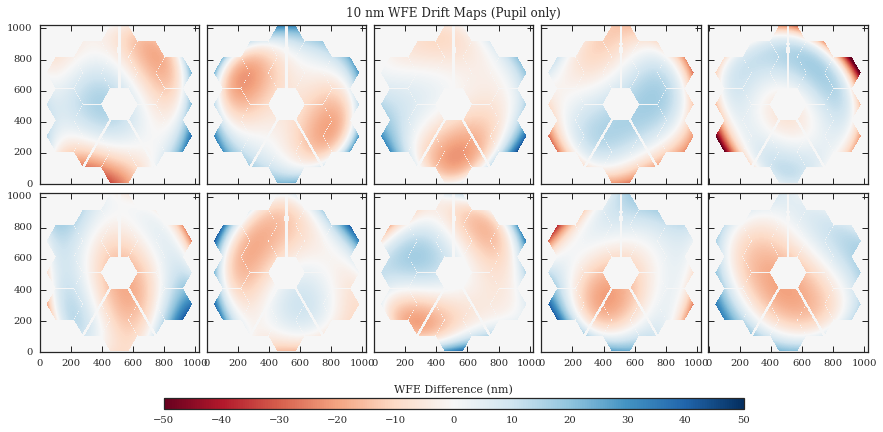

In [10]:
wfe_ind = 3
vlim = 5*drift_list[wfe_ind]
opd_ref_list = opd_ref_list_all[wfe_ind]

fig, axes = plt.subplots(2,5,figsize=(11.5,6))
for i,ax in enumerate(axes.flat):
    im = ax.imshow((opd_sci_list[i]-opd_ref_list[i])*1000, cmap='RdBu', vmin=-vlim, vmax=vlim)
    ax.set_aspect('equal')
    if i % 5 > 0: ax.set_yticklabels([])
    if i < 5: ax.set_xticklabels([])

#fig.tight_layout()
fig.subplots_adjust(wspace=0.05, hspace=0.05, top=0.94, bottom=0.18, left=0, right=1)

cbar_ax = fig.add_axes([0.15, 0.05, 0.7, 0.025])
fig.colorbar(im, cax=cbar_ax, orientation = 'horizontal')
cbar_ax.set_xlabel('WFE Difference (nm)')
cbar_ax.xaxis.set_label_position('top');

fig.suptitle('{:.0f} nm WFE Drift Maps (Pupil only)'.format(drift_list[wfe_ind]));
#fig.suptitle('WFE Drift Maps (Pupil only)');
#outdir = '/Users/jwstnircam/Desktop/NRC_Coronagraph/WFE_models/'
#fig.savefig(outdir+'wfe_diff_10nm_lebreton.pdf')

## Science PSFs

In [11]:
psf_list = [
    ('F323N',  None     ,  None      ), # Direct Imaging
    ('F335M', 'MASK335R', 'CIRCLYOT' ), # Coronagraphic spot observations
    ('F335M', 'MASKLWB' , 'WEDGELYOT')] # Coronagraphic bar observations


# Filters and masks
filt_direct, _,     _      = psf_list[0]
filt_coron,  mask,  pupil  = psf_list[1]
filt_coron2, mask2, pupil2 = psf_list[2]

In [12]:
# Direct imaging
%time psf_star_direct = [sn.get_psf(opd, header, filt_direct, None, None) for opd in opd_sci_list]
psf_planet_direct = psf_star_direct[0] # Planet and star PSFs are the same

CPU times: user 6.96 s, sys: 2.68 s, total: 9.64 s
Wall time: 25.6 s


In [13]:
# Get all planet and stellar PSFs for coronagraphic observations
# We really only need a single planet PSF
psf_planet_coron = sn.get_psf(opd_sci_list[0], header, filt_coron, None, pupil) 
%time psf_star_coron = [sn.get_psf(opd, header, filt_coron, mask, pupil) for opd in opd_sci_list]

CPU times: user 11.8 s, sys: 6.36 s, total: 18.1 s
Wall time: 6min 7s


In [14]:
# Bar Occulter
psf_planet_coron2 = sn.get_psf(opd_sci_list[0], header, filt_coron2, None, pupil2)
%time psf_star_coron2 = [sn.get_psf(opd, header, filt_coron2, mask2, pupil2) for opd in opd_sci_list]

CPU times: user 11.6 s, sys: 6.35 s, total: 18 s
Wall time: 4min 29s


In [12]:
# Get all planet and stellar PSFs for coronagraphic observations
# We really only need a single planet PSF
psf_planet_coron = sn.get_psf(opd_sci_list[0], header, filt_coron, None, pupil) 
%time psf_star_coron = [sn.get_psf(opd, header, filt_coron, mask, pupil) for opd in opd_sci_list[0:2]]

CPU times: user 28.9 s, sys: 7.69 s, total: 36.6 s
Wall time: 1min 32s


## Reference PSFs

In [15]:
# Get all reference PSFs for direct observations
# This includes the multiple drift values
%time psf_ref_direct_all = sn.gen_psf_ref_all(opd_ref_list_all, header, filt_direct, None, None)

CPU times: user 28.3 s, sys: 11 s, total: 39.2 s
Wall time: 1min 43s


In [16]:
# Get all reference PSFs for coronagraphic observations
# This includes the multiple drift values
%time psf_ref_coron_all = sn.gen_psf_ref_all(opd_ref_list_all, header, filt_coron, mask, pupil)

CPU times: user 46.8 s, sys: 28.7 s, total: 1min 15s
Wall time: 24min 33s


In [17]:
# Get all reference PSFs for coronagraphic observations
# This includes the multiple drift values
%time psf_ref_coron_all2 = sn.gen_psf_ref_all(opd_ref_list_all, header, filt_coron2, mask2, pupil2)

CPU times: user 45.8 s, sys: 26 s, total: 1min 11s
Wall time: 17min 53s


In [15]:
# Get all reference PSFs for coronagraphic observations
# This includes the multiple drift values
opd_ref_list_all2 = []
for opd_ref_list in opd_ref_list_all:
    opd_ref_list_all2.append(opd_ref_list[0:2])
%time psf_ref_coron_all = sn.gen_psf_ref_all(opd_ref_list_all2, header, filt_coron, mask, pupil)

CPU times: user 2min, sys: 25 s, total: 2min 25s
Wall time: 6min 9s


In [27]:
opd_test = opd_ref_list_all2[0][0]
opd_test.shape

(1024, 1024)

## Speckle Noise Images and Contrast Curves

In [16]:
speckle_spot   = [sn.speckle_noise_image(psf_star_coron, psf_ref) 
                  for psf_ref in psf_ref_coron_all]
contrast_spot  = [sn.get_contrast(speckle_image, psf_planet_coron) 
                  for speckle_image in speckle_spot]

In [62]:
def get_contrast_old(psf0,psf1,psf2):
    """
    For science and reference PSFs, return the contrast curve.
    Assumes no noise other than residual speckle noise.
    psf0 is the planet PSF
    psf1 is the stellar PSF
    psf2 is the reference PSF
    """

    # PSF subtraction
    from copy import deepcopy
    psf_diff = deepcopy(psf1)
    psf_diff[0].data = (psf1[0].data - psf2[0].data)
    psf_diff[1].data = (psf1[1].data - psf2[1].data)

    # Radial noise profiles of PSF difference
    rr0, stds0 = webbpsf.radial_profile(psf_diff, ext=0, stddev=True)
    rr1, stds1 = webbpsf.radial_profile(psf_diff, ext=1, stddev=True)

    ## Total planet signal at a radius of 0.5"
    #rr_psf0, mn_psf0, ee_psf0 = webbpsf.radial_profile(psf0, ext=0, EE=True)
    #rad_asec = 0.5
    #npix = np.pi * (rad_asec / psf0[0].header['PIXELSCL'])**2
    ## Get the encircled energy of planet at radius
    #planet_signal = np.interp(rad_asec, rr_psf0, ee_psf0)
    ## nsigma of planet signal relative to noise
    #contrast =  np.sqrt(stds0**2 * npix) / planet_signal

    contrast = stds0 / np.max(psf0[0].data)

    return rr0, contrast

def get_contrast_all_old(psf_planet, psf_star_all, psf_ref_all):
    """
    Return a list of contrast curves based on a list of PSFs
    """
    nopd = len(psf_star_all)
    return [get_contrast_old(psf_planet,psf_star_all[i],psf_ref_all[i]) for i in range(nopd)]


In [43]:
psf_star_coron[0]

In [44]:
contrast_spot2 = [get_contrast_all_old(psf_planet_coron, psf_star_coron, psf_ref_coron)
                  for psf_ref_coron in psf_ref_coron_all]


In [32]:
hdu = fits.PrimaryHDU(opd_ref_list_all[0][0])
hdu.header = header.copy()
opd1 = fits.HDUList([hdu])

hdu = fits.PrimaryHDU(opd_ref_list_all[1][0])
hdu.header = header.copy()
opd2 = fits.HDUList([hdu])

hdu = fits.PrimaryHDU(opd_ref_list_all[2][0])
hdu.header = header.copy()
opd5 = fits.HDUList([hdu])

hdu = fits.PrimaryHDU(opd_ref_list_all[3][0])
hdu.header = header.copy()
opd10 = fits.HDUList([hdu])

nrc1  = pynrc.NIRCam('F335M', mask='MASK335R', pupil='CIRCLYOT', oversample=4, fov_pix=159, opd=opd1, save=False)
nrc2  = pynrc.NIRCam('F335M', mask='MASK335R', pupil='CIRCLYOT', oversample=4, fov_pix=159, opd=opd2, save=False)
nrc5  = pynrc.NIRCam('F335M', mask='MASK335R', pupil='CIRCLYOT', oversample=4, fov_pix=159, opd=opd5, save=False)
nrc10 = pynrc.NIRCam('F335M', mask='MASK335R', pupil='CIRCLYOT', oversample=4, fov_pix=159, opd=opd10, save=False)

In [59]:
nrc0 = pynrc.NIRCam('F335M', mask='MASK335R', pupil='CIRCLYOT', oversample=4, fov_pix=159)
im, im_over = nrc0.gen_psf(return_oversample=True)
hdu = fits.PrimaryHDU(im_over)
hdu.header['EXTNAME'] = ('OVERSAMP')
hdu.header['OVERSAMP'] = 4
hdu.header['DET_SAMP'] = 4
hdu.header['PIXELSCL'] = 0.063 / hdu.header['OVERSAMP']
hdulist = fits.HDUList([hdu])

hdu = fits.PrimaryHDU(im)
hdu.header['EXTNAME'] = ('DET_SAMP')
hdu.header['OVERSAMP'] = 1
hdu.header['DET_SAMP'] = 4
hdu.header['PIXELSCL'] = 0.063
hdulist.append(hdu)

psf_star_coron3 = hdulist


In [54]:
psf_ref_coron_all3 = []
for nrc in [nrc1, nrc2, nrc5, nrc10]:
    
    im, im_over = nrc.gen_psf(return_oversample=True)
    hdu = fits.PrimaryHDU(im_over)
    hdu.header['EXTNAME'] = ('OVERSAMP')
    hdu.header['OVERSAMP'] = 4
    hdu.header['DET_SAMP'] = 4
    hdu.header['PIXELSCL'] = 0.063 / hdu.header['OVERSAMP']
    hdulist = fits.HDUList([hdu])

    hdu = fits.PrimaryHDU(im)
    hdu.header['EXTNAME'] = ('DET_SAMP')
    hdu.header['OVERSAMP'] = 1
    hdu.header['DET_SAMP'] = 4
    hdu.header['PIXELSCL'] = 0.063
    hdulist.append(hdu)
    
    psf_ref_coron_all3.append(hdulist)


In [63]:
contrast_spot3 = [get_contrast_old(psf_planet_coron, psf_star_coron3, psf_ref_coron)
                  for psf_ref_coron in psf_ref_coron_all3]

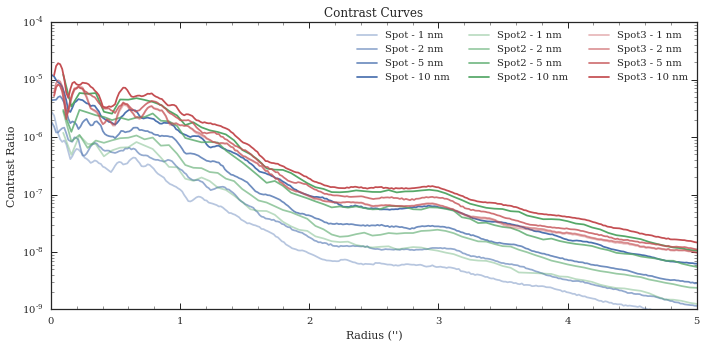

In [64]:
fig,ax = plt.subplots(1,1, figsize=(10, 5))

current_palette = sns.color_palette()
pal1 = sns.color_palette("deep")
pal2 = sns.color_palette("muted")

for j,drift in enumerate(drift_list):
    r, c = contrast_spot[j]
    ax.semilogy(r, c, color=pal1[0], label='Spot - {:.0f} nm'.format(drift), alpha=0.2*(j+2))

for j,drift in enumerate(drift_list):
    r, c = contrast_spot2[j][0]
    ax.semilogy(r, c, color=pal1[1], label='Spot2 - {:.0f} nm'.format(drift), alpha=0.2*(j+2))

for j,drift in enumerate(drift_list):
    r, c = contrast_spot3[j]
    ax.semilogy(r, c, color=pal1[2], label='Spot3 - {:.0f} nm'.format(drift), alpha=0.2*(j+2))

    
ax.legend()
ax.set_xlim([0,5]);
ax.set_ylim([1e-9,1e-4]);
ax.set_ylabel('Contrast Ratio')
ax.minorticks_on()
ax.legend(ncol=3)
ax.set_xlabel("Radius ('')")

ax.set_title('Contrast Curves')

fig.tight_layout()
#outdir = '/Users/jwstnircam/Desktop/NRC_Coronagraph/WFE_models/'
#fig.savefig(outdir+filt_coron+'_contrast_lebreton.pdf', facecolor='none')


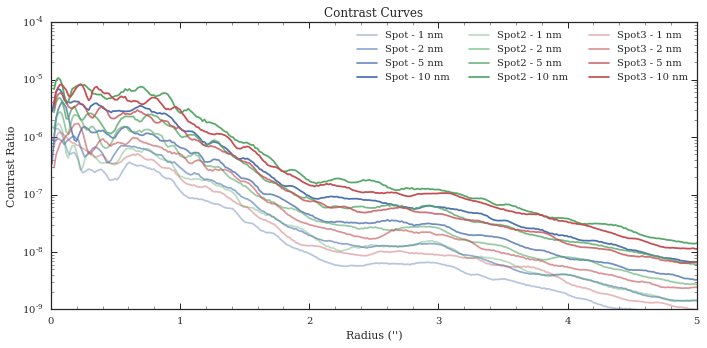

In [46]:
fig,ax = plt.subplots(1,1, figsize=(10, 5))

current_palette = sns.color_palette()
pal1 = sns.color_palette("deep")
pal2 = sns.color_palette("muted")

for j,drift in enumerate(drift_list):
    r, c = contrast_spot[j]
    ax.semilogy(r, c, color=pal1[0], label='Spot - {:.0f} nm'.format(drift), alpha=0.2*(j+2))

for j,drift in enumerate(drift_list):
    r, c = contrast_spot2[j][0]
    ax.semilogy(r, c, color=pal1[1], label='Spot2 - {:.0f} nm'.format(drift), alpha=0.2*(j+2))

for j,drift in enumerate(drift_list):
    r, c = contrast_spot2[j][1]
    ax.semilogy(r, c, color=pal1[2], label='Spot3 - {:.0f} nm'.format(drift), alpha=0.2*(j+2))

    
ax.legend()
ax.set_xlim([0,5]);
ax.set_ylim([1e-9,1e-4]);
ax.set_ylabel('Contrast Ratio')
ax.minorticks_on()
ax.legend(ncol=3)
ax.set_xlabel("Radius ('')")

ax.set_title('Contrast Curves')

fig.tight_layout()
#outdir = '/Users/jwstnircam/Desktop/NRC_Coronagraph/WFE_models/'
#fig.savefig(outdir+filt_coron+'_contrast_lebreton.pdf', facecolor='none')


In [18]:
# Create a series of speckle noise images for each drift amount
speckle_direct = [sn.speckle_noise_image(psf_star_direct, psf_ref) 
                  for psf_ref in psf_ref_direct_all]
speckle_spot  = [sn.speckle_noise_image(psf_star_coron, psf_ref) 
                  for psf_ref in psf_ref_coron_all]
speckle_bar   = [sn.speckle_noise_image(psf_star_coron2, psf_ref) 
                  for psf_ref in psf_ref_coron_all2]

In [19]:
contrast_direct = [sn.get_contrast(speckle_image, psf_planet_direct) 
                    for speckle_image in speckle_direct]
contrast_spot   = [sn.get_contrast(speckle_image, psf_planet_coron) 
                    for speckle_image in speckle_spot]
contrast_bar    = [sn.get_contrast(speckle_image, psf_planet_coron) 
                    for speckle_image in speckle_bar]

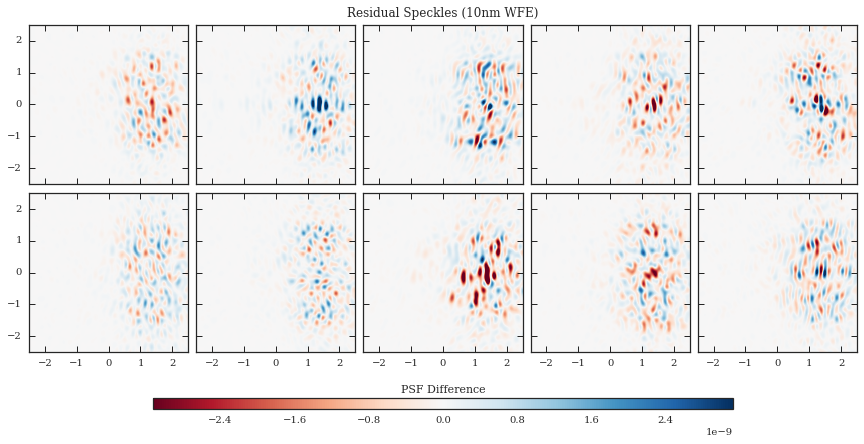

In [34]:
vlim = 5e-8
fig, axes = plt.subplots(2,5,figsize=(11.5,6))
ext = 0
if ext==0: vlim = vlim/16

wfe_ind = 3
psf_ref_coron = psf_ref_coron_all2[wfe_ind]
for i,ax in enumerate(axes.flat):
    hdu1 = psf_star_coron2[i]
    hdu2 = psf_ref_coron[i]
    
    im = webbpsf.display_psf_difference(hdu1,hdu2,ext,ext, -vlim,vlim, title='', imagecrop=5, 
                                        colorbar=False, cmap='RdBu', ax=ax, return_ax=True)
    if i % 5 > 0: ax.set_yticklabels([])
    if i < 5: ax.set_xticklabels([])

#fig.tight_layout()
fig.subplots_adjust(wspace=0.05, hspace=0.05, top=0.94, bottom=0.18, left=0, right=1)

cbar_ax = fig.add_axes([0.15, 0.05, 0.7, 0.025])
fig.colorbar(im.images[0], cax=cbar_ax, orientation = 'horizontal')
cbar_ax.set_xlabel('PSF Difference')
cbar_ax.xaxis.set_label_position('top');

fig.suptitle('Residual Speckles ({:.0f}nm WFE)'.format(drift_list[wfe_ind]));

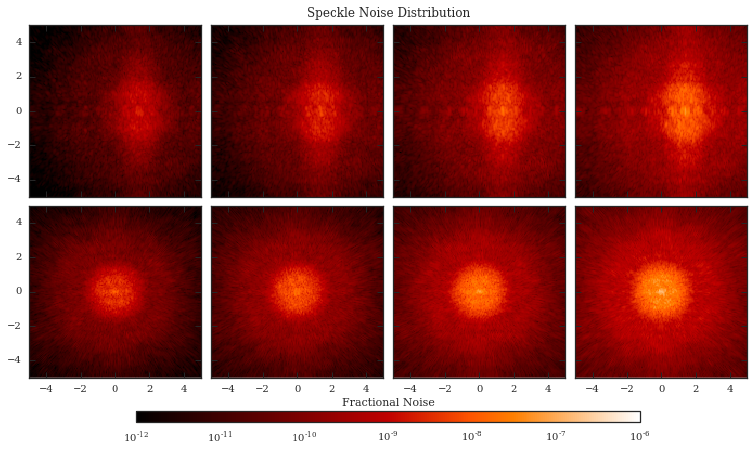

In [23]:
#plt.imshow(speckle_spot[2][1].data[50:100,50:100],vmin=1e-10,vmax=1e-8)
#speckle_spot[2][1].data.max()

hdu = speckle_spot[3]
ext = 1
vmin = 1e-12; vmax = 1e-6
if ext==0: vmin /= 16; vmax /= 16
#im = webbpsf.display_psf(hdu,ext, imagecrop=5, vmin=vmin,vmax=vmax)

fig, axes = plt.subplots(2,4,figsize=(10,6.2))

for i, ax in enumerate(axes[0]):
    hdu = speckle_bar[i]
    im = webbpsf.display_psf(hdu, ext, vmin=vmin, vmax=vmax, title='', colorbar=False, imagecrop=10,
                             ax=ax, return_ax=True)
    ax.set_xticklabels([])
    if i > 0: ax.set_yticklabels([])
    
for i, ax in enumerate(axes[1]):
    hdu = speckle_spot[i]
    im = webbpsf.display_psf(hdu, ext, vmin=vmin, vmax=vmax, title='', colorbar=False, imagecrop=10,
                             ax=ax, return_ax=True)
    
    if i > 0: ax.set_yticklabels([])

#fig.tight_layout()
fig.subplots_adjust(wspace=0.05, hspace=0.05, top=0.94, bottom=0.15, left=0, right=1)

cbar_ax = fig.add_axes([0.15, 0.05, 0.7, 0.025])
fig.colorbar(im.images[0], cax=cbar_ax, orientation = 'horizontal')
cbar_ax.set_xlabel('Fractional Noise')
cbar_ax.xaxis.set_label_position('top');

fig.suptitle('Speckle Noise Distribution');

1.00
1.00
1.00
1.00


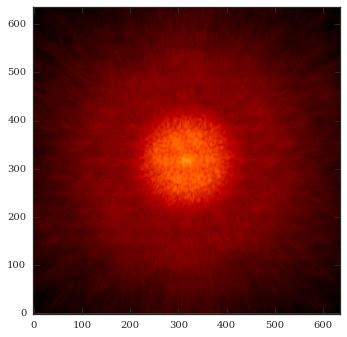

In [22]:
ext=0

ndrift = len(drift_list)
ratio = [np.median(speckle_spot[i][ext].data / speckle_spot[0][ext].data) for i in range(ndrift)]
ratio2 = [np.median(speckle_direct[i][ext].data / speckle_direct[0][ext].data) for i in range(ndrift)]
#plt.plot(drift_list, ratio)
#plt.plot(drift_list, ratio2)
#plt.imshow(speckle_spot[2][ext].data / speckle_spot[0][ext].data)

vmin = 1e-13; vmax = 1e-8
norm = matplotlib.colors.LogNorm(vmin=vmin, vmax=vmax)

speckle_scaled = []
for i in range(ndrift):
    im = speckle_spot[i][ext].data / ratio[i]
    speckle_scaled.append(im)
    temp = np.median(speckle_spot[0][ext].data / im)
    print('{:.2f}'.format(temp))
speckle_master = np.mean(np.array(speckle_scaled), axis=0)

plt.imshow(speckle_master, norm=norm)

## Plot Contrast Curves

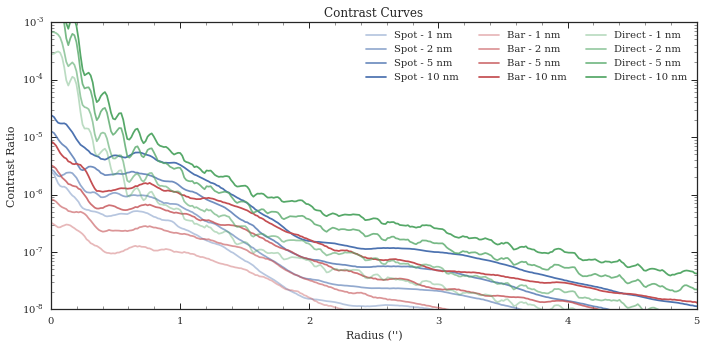

In [33]:
fig,ax = plt.subplots(1,1, figsize=(10, 5))

current_palette = sns.color_palette()
pal1 = sns.color_palette("deep")
pal2 = sns.color_palette("muted")

for j,drift in enumerate(drift_list):
    r, c = contrast_spot[j]
    ax.semilogy(r, c, color=pal1[0], label='Spot - {:.0f} nm'.format(drift), alpha=0.2*(j+2))
    
for j,drift in enumerate(drift_list):
    r, c = contrast_bar[j]
    ax.semilogy(r, c, color=pal1[2], label='Bar - {:.0f} nm'.format(drift), alpha=0.2*(j+2))

for j,drift in enumerate(drift_list):
    r, c = contrast_direct[j]
    ax.semilogy(r, c, color=pal1[1], label='Direct - {:.0f} nm'.format(drift), alpha=0.2*(j+2))

    
ax.legend()
ax.set_xlim([0,5]);
ax.set_ylim([1e-8,1e-3]);
ax.set_ylabel('Contrast Ratio')
ax.minorticks_on()
ax.legend(ncol=3)
ax.set_xlabel("Radius ('')")

ax.set_title('Contrast Curves')

fig.tight_layout()
outdir = '/Users/jwstnircam/Desktop/NRC_Coronagraph/WFE_models/'
#fig.savefig(outdir+filt_coron+'_contrast_lebreton.pdf', facecolor='none')


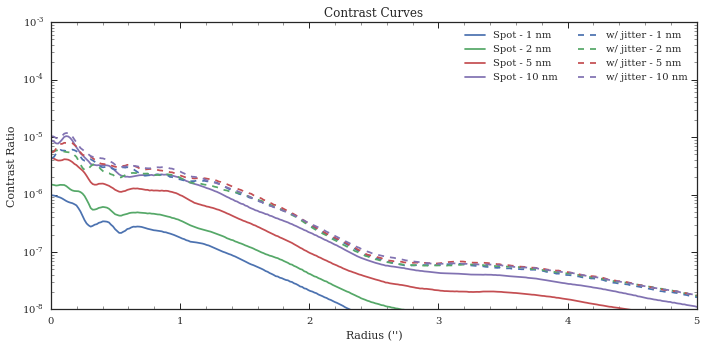

In [28]:
fig,ax = plt.subplots(1,1, figsize=(10, 5))

current_palette = sns.color_palette()
pal1 = sns.color_palette("deep")
pal2 = sns.color_palette("muted")

for j,drift in enumerate(drift_list):
    r, c = contrast_spot[j]
    ax.semilogy(r, c, color=pal1[j], label='Spot - {:.0f} nm'.format(drift))
    
for j,drift in enumerate(drift_list):
    r, c = contrast_bar[j]
    ax.semilogy(r, c, color=pal1[j], label='w/ jitter - {:.0f} nm'.format(drift), ls='--')

ax.legend()
ax.set_xlim([0,5]);
ax.set_ylim([1e-8,1e-3]);
ax.set_ylabel('Contrast Ratio')
ax.minorticks_on()
ax.legend(ncol=2)
ax.set_xlabel("Radius ('')")

ax.set_title('Contrast Curves')

fig.tight_layout()
outdir = '/Users/jwstnircam/Desktop/NRC_Coronagraph/WFE_models/'
#fig.savefig(outdir+filt_coron+'_contrast_lebreton.pdf', facecolor='none')
